<a href="https://colab.research.google.com/github/TobyChen320/DS-Unit-2-Linear-Models/blob/master/Toby_Chen_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
subset=df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS')&(df['SALE_PRICE']>100000)&(df['SALE_PRICE']<2000000)]
subset

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019


In [7]:
subset['SALE_DATE']=pd.to_datetime(subset['SALE_DATE'])
train=subset[(subset['SALE_DATE']>='2019-01-01')&(subset['SALE_DATE']<'2019-03-31')]
train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,OTHER,01 ONE FAMILY DWELLINGS,1,4081,44,NaN,A2,10 SEAFOAM STREET,NaN,10306.0,1.0,0.0,1.0,"2,400",921.0,1950.0,1,A2,330000,2019-03-29
18130,5,OTHER,01 ONE FAMILY DWELLINGS,1,2373,201,NaN,A5,74 MCVEIGH AVE,NaN,10314.0,1.0,0.0,1.0,"2,450",2128.0,1980.0,1,A5,690000,2019-03-29
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,NaN,A1,479 VILLA AVENUE,NaN,10302.0,1.0,0.0,1.0,"4,361",1807.0,2018.0,1,A1,610949,2019-03-29
18134,5,OTHER,01 ONE FAMILY DWELLINGS,1,3395,37,NaN,A2,63 NUGENT AVENUE,NaN,10305.0,1.0,0.0,1.0,"6,000",621.0,1930.0,1,A2,520000,2019-03-29


In [8]:
test=subset[(subset['SALE_DATE']>='2019-04-01')&(subset['SALE_DATE']<='2019-04-30')]
test

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,558 ELLSWORTH AVENUE,NaN,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,16 BAY RIDGE PARKWAY,NaN,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,NaN,A5,1247 EAST 40TH STREET,NaN,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,NaN,A9,2314 PLUMB 2ND STREET,NaN,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,2019-04-30
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,2019-04-30
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,2019-04-30
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,2019-04-30


In [9]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,5,7,1,2,13,2497,1,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,117-45 125TH STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1204,2360,2507,2476,919,2,1,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [10]:
train.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [11]:
# When I try to leave the 'SALE_DATE' column in, it spits out an error.
target = 'SALE_PRICE'
high_cardinality = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'EASE-MENT','SALE_DATE']
features = train.columns.drop(high_cardinality+[target]).to_list()
features

['BLOCK',
 'LOT',
 'ZIP_CODE',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'TAX_CLASS_AT_TIME_OF_SALE']

In [12]:
import category_encoders as ce 
X_train=train[features]
y_train=train[target]
X_test=test[features]
y_test=test[target]
encoder = ce.one_hot.OneHotEncoder()
X_train_enc=encoder.fit_transform(X_train)
X_test_enc=encoder.transform(X_test)
X_train_enc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...
18129,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


In [13]:
X_test_enc

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
18235,5913,878,10471.0,1.0,0.0,1.0,2272.0,1930.0,1
18239,5488,48,10465.0,1.0,0.0,1.0,720.0,1935.0,1
18244,5936,31,11209.0,1.0,0.0,1.0,2210.0,1925.0,1
18280,7813,24,11210.0,1.0,0.0,1.0,1520.0,1915.0,1
18285,8831,160,11229.0,1.0,0.0,1.0,840.0,1925.0,1
...,...,...,...,...,...,...,...,...,...
23029,13215,3,11422.0,1.0,0.0,1.0,1478.0,1925.0,1
23031,11612,73,11420.0,1.0,0.0,1.0,1280.0,1930.0,1
23032,11808,50,11420.0,1.0,0.0,1.0,1333.0,1945.0,1
23033,12295,23,11434.0,1.0,0.0,1.0,1020.0,1935.0,1


In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
selector=SelectKBest(score_func=f_regression, k=9)
X_train_kbest=selector.fit_transform(X_train_enc, y_train)
X_test_kbest=selector.transform(X_test_enc)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
mae_list = []
for k in range(1, X_train_enc.shape[1] + 1):
  print(f'Using top {k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_enc, y_train)
  X_test_kbest = selector.transform(X_test_enc)
  model = LinearRegression()
  model.fit(X_train_kbest, y_train)
  y_pred = model.predict(X_test_kbest)
  mae = mean_absolute_error(y_pred, y_test)
  print(f'MAE: {mae}')
  mae_list.append(mae)

Using top 1 features
MAE: 183640.5858012459
Using top 2 features
MAE: 184003.16718394245
Using top 3 features
MAE: 183943.3499084699
Using top 4 features
MAE: 167050.43208105507
Using top 5 features
MAE: 167907.75667209478
Using top 6 features
MAE: 167907.75667209533
Using top 7 features
MAE: 167912.6781965663
Using top 8 features
MAE: 167704.58795917808
Using top 9 features
MAE: 167704.58795917808


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

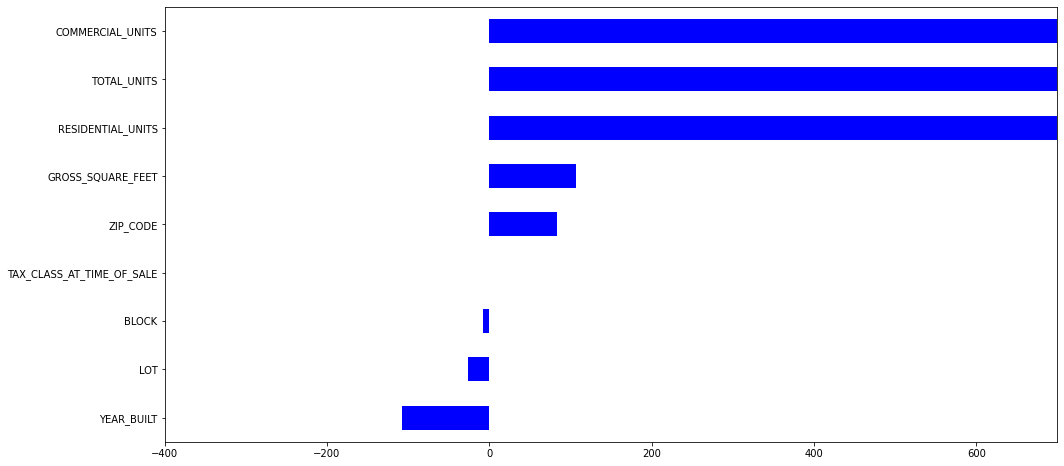

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
alphas = [1]
ridge=RidgeCV(alphas=alphas, normalize=True)
for alpha in alphas:
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='b')
    plt.xlim(-400,700)
    plt.show()